In [1]:
# Auto reload modules.
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import seaborn as sns

params = {
    "text.color": (0.25, 0.25, 0.25),
    "figure.figsize": [7, 5],
    "font.size": 7,
}

plt.rcParams.update(params)

import pandas as pd

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

from datetime import datetime
import re
from tabulate import tabulate
from collections import Counter
import requests
from tqdm.notebook import tqdm

from utils import (
    DCAT_CLASS_DATASET,
    DCAT_CLASS_DISTRIBUTION,
    VOCAB_EU_THEME,
    VOCAB_EU_FREQUENCY,
    HIDDEN_NULLS,
)
from utils import check_text_properties

import warnings

warnings.simplefilter("ignore", category=(UserWarning, FutureWarning))

In [3]:
# Constants
# Dataset links are composed of this baselink and the identifier for each dataset.
BASELINK_DATASHOP = (
    "https://www.zh.ch/de/politik-staat/statistik-daten/datenkatalog.html#/datasets/"
)

MDV_DATA_PATH = "_data/01_mdv_metadata.parq"

# Default figure size for Quarto HTML output.
FIGSIZE = (7, 5)

In this notebook we perform a thorough analysis and quality check of the [OGD metadata catalog of the Canton of Zurich](https://www.zh.ch/de/politik-staat/statistik-daten/datenkatalog.html#/).

This check is based on two ideas:

- We **treat the metadata catalog as a regular dataset and do a structured and detailed exploratory data analysis (EDA).** 
- We **use an LLM to analyze the content of titles and descriptions to discover semantic deficits and nonsensical entries that are hard to catch otherwise**.

We set up the code to perform most of the checks automatically. It should be easy to adapt this notebook to other data catalogues that conform to the [DCAT-AP CH standard](https://www.dcat-ap.ch/).

This notebooks produces two outputs:

- a **HTML report** (most likely the document you are reading right now)
- an **Excelfile with all major issues**

# Load data

**Retrieve data from the metadata API.**

In [4]:
# Retrieve metadata for all datasets from MDV API.
raw = requests.get("https://www.web.statistik.zh.ch/ogd/daten/zhweb.json").json()[
    "dataset"
]
df = pd.DataFrame(pd.json_normalize(raw))
df.to_parquet(MDV_DATA_PATH)

In [5]:
df = pd.read_parquet(MDV_DATA_PATH)
if len(df) == 0:
    raise ValueError("No data retrieved.")
else:
    print(f"Retrieved {len(df)} datasets.")

Retrieved 796 datasets.


**Load DCAT standard for datasets**. 

The data is derived from [here](https://www.dcat-ap.ch/releases/2.0/dcat-ap-ch.html#Class:Dataset).

- `uri` should be identical to our variable names. 
- `range` specifies the range of values that is expected for the property.
- `requirement_level` denotes whether the class / property is mandatory (M), recommended (R) or optional (O).
- `cardinality` specifies the minimum number of values that MUST be provided for that property and the maximum number of values that MAY be provided. 

In [6]:
dcat_ds = pd.DataFrame(
    DCAT_CLASS_DATASET,
    columns=["property", "uri", "range", "requirement", "cardinality"],
)

dcat_ds.drop("property", axis=1, inplace=True)

dcat_ds.uri = dcat_ds.uri.apply(
    lambda x: x.replace("dcat:", "")
    .replace("dct:", "")
    .replace("prov:", "")
    .replace("schema:", "")
    .replace("foaf:", "")
)

display(dcat_ds)
print()

,uri,range,requirement,cardinality
0,contactPoint,vcard:Kind,M,1..n
1,description,rdfs:Literal,M,1..n
2,identifier,rdfs:Literal,M,1..n
3,publisher,foaf:Agent,M,1..1
4,title,rdfs:Literal,M,1..n
5,distribution,dcat:Distribution,R,0..n
6,keyword,rdfs:Literal,R,0..n
7,landingPage,foaf:Document,R,0..n
8,issued,"rdfs:Literal (typed as xsd:date, xsd:dateTime,...",R,0..1
9,spatial,dct:Location,R,0..n


**Load DCAT standard for distributions**. 

The data is derived from [here](https://www.dcat-ap.ch/releases/2.0/dcat-ap-ch.html#Class:Distribution).

In [7]:
dcat_dist = pd.DataFrame(
    DCAT_CLASS_DISTRIBUTION,
    columns=["uri", "range", "requirement", "cardinality"],
)

dcat_dist.uri = dcat_dist.uri.apply(
    lambda x: x.replace("dcat:", "")
    .replace("dct:", "")
    .replace("prov:", "")
    .replace("schema:", "")
    .replace("foaf:", "")
    .replace("dcatap:", "")
    .replace("spdx:", "")
)

dcat_dist

,uri,range,requirement,cardinality
0,accessURL,rdfs:Resource,M,1..n
1,license,dct:LicenseDocument,M,1..1
2,availability,skos:Concept,R,0..1
3,description,rdfs:Literal,R,0..n
4,format,dct:MediaTypeOrExtent,R,0..1
5,rights,dct:RightsStatement,R,0..1
6,title,rdfs:Literal,R,0..n
7,modified,"rdfs:Literal (typed as xsd:date, xsd:dateTime,...",R,0..1
8,accessService,dcat:DataService,O,0..n
9,byteSize,rdfs:Literal (typed as xsd:decimal),O,0..1


In [8]:
# Create an empty list to store issues and errors.
issues = []

# Global checks

## Structure

In [9]:
print(
    f"We have {len(df):,.0f} datasets in the catalogue and {df.shape[1]} properties.\n"
)
df.info(memory_usage="deep")

We have 796 datasets in the catalogue and 16 properties.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   identifier          796 non-null    object
 1   title               796 non-null    object
 2   description         796 non-null    object
 3   issued              796 non-null    object
 4   modified            796 non-null    object
 5   publisher           796 non-null    object
 6   contactPoint        796 non-null    object
 7   theme               796 non-null    object
 8   keyword             776 non-null    object
 9   landingPage         396 non-null    object
 10  startDate           492 non-null    object
 11  endDate             473 non-null    object
 12  accrualPeriodicity  794 non-null    object
 13  seeAlso             464 non-null    object
 14  relation            433 non-null    object
 15  distribution    

## Properties

- Check which properties (**mandatory**, **recommened** or **optional**) are present in the metadata.
- Check which **additional** properties are present, that aren't defined in the DCAT standard.

In [10]:
# Extract the various requirements for each property.

mandatory = dcat_ds[dcat_ds.requirement == "M"].uri.tolist()
recommended = dcat_ds[dcat_ds.requirement == "R"].uri.tolist()
optional = dcat_ds[dcat_ds.requirement == "O"].uri.tolist()

print("The metadata catalogue contains the following properties:\n")
for name, cols in zip(
    ["mandatory", "recommended", "optional"],
    [mandatory, recommended, optional],
):
    present = [x for x in cols if x in df.columns]
    missing = [x for x in cols if x not in df.columns]
    missing_len = len(missing)
    if missing == []:
        missing = ""
        print(
            f"{len(cols) - missing_len} of {len(cols)} {name} properties.\n{present}\n{missing_len} missing."
        )
    else:
        print(
            f"{len(cols) - missing_len} of {len(cols)} {name} properties.\n{present}\n{missing_len} missing: {missing}"
        )
    print()

additional = [x for x in df.columns if x not in dcat_ds.uri.tolist()]
print(f"{len(additional)} additional properties: {additional}")

The metadata catalogue contains the following properties:

5 of 5 mandatory properties.
['contactPoint', 'description', 'identifier', 'publisher', 'title']
0 missing.

6 of 8 recommended properties.
['distribution', 'keyword', 'landingPage', 'issued', 'theme', 'modified']
2 missing: ['spatial', 'temporal']

2 of 10 optional properties.
['accrualPeriodicity', 'relation']
8 missing: ['accessRights', 'conformsTo', 'page', 'image', 'isReferencedBy', 'language', 'qualifiedAttribution', 'qualifiedRelation']

3 additional properties: ['startDate', 'endDate', 'seeAlso']


## Missing values

In [11]:
# Extract the various requirements for each property that are actually present in the dataset.
present_mandatory = [x for x in mandatory if x in df.columns]
present_recommended = [x for x in recommended if x in df.columns]
present_optional = [x for x in optional if x in df.columns]

# Check for missing values in the dataset according to the requirements.
for req, cols in zip(
    ["mandatory", "recommended", "optional", "additional"],
    [present_mandatory, present_recommended, present_optional, additional],
):
    # Add issues to the list.
    for prop in cols:
        issues.extend(
            [
                (x, f"Missing value in {req} property «{prop}»", "Missing values")
                for x in df[df[prop].isna()].identifier
            ]
        )

    missing = [(x, df[x].isna().sum()) for x in cols if df[x].isna().sum() > 0]
    if missing == []:
        print(f"Missing {req} properties:\nNone")
        print()
    else:
        tmp = pd.DataFrame(missing, columns=["property", "missing_count"]).sort_values(
            "missing_count", ascending=False
        )
        print(f"Missing in {req} properties:")
        print(
            tabulate(
                tmp[["property", "missing_count"]], headers="keys", showindex=False
            )
        )
        print()

Missing mandatory properties:
None

Missing in recommended properties:
property       missing_count
-----------  ---------------
landingPage              400
keyword                   20

Missing in optional properties:
property              missing_count
------------------  ---------------
relation                        363
accrualPeriodicity                2

Missing in additional properties:
property      missing_count
----------  ---------------
seeAlso                 332
endDate                 323
startDate               304



## Hidden nulls

In [12]:
# Check for «hidden nulls», e.g. strings that are not empty (and therefore satisfy the DCAT standard) but are not meaningful either.
# Define these according to your needs and imagination of possible hidden nulls in utils.py.

results = []
for req, cols in zip(
    ["mandatory", "recommended", "optional"],
    [present_mandatory, present_recommended, present_optional],
):
    for col in cols:
        empty = df[col].apply(
            lambda x: x.lower() in HIDDEN_NULLS if isinstance(x, str) else None
        )

        # Add issues to the list.
        tmp = df.loc[empty[empty == True].index, [col, "identifier"]]
        if len(tmp) > 0:
            issues.extend(
                [
                    (x, f"Hidden null in {req} property «{col}»", "Hidden nulls")
                    for x in tmp.identifier
                ]
            )

        empty_strings_found = df.loc[empty[empty == True].index, col].unique()
        if empty.sum() > 0:
            message = f"{empty.sum()} hidden null strings in {req} property «{col}»: {empty_strings_found}"
            results.append(message)

if results != []:
    print("\n".join(results))
else:
    print("No empty strings found.")

57 hidden null strings in mandatory property «description»: ['null']


In [13]:
# Check for empty lists or dictionaries.

empty_datatypes = ([], {})
results = []
for req, cols in zip(
    ["mandatory", "recommended", "optional"],
    [present_mandatory, present_recommended, present_optional],
):
    for col in cols:
        empty = df[col].apply(
            lambda x: x in empty_datatypes if isinstance(x, (list, dict)) else None
        )

        # Add issues to the list.
        tmp = df.loc[empty[empty == True].index, [col, "identifier"]]
        if len(tmp) > 0:
            issues.extend(
                [
                    (
                        x,
                        f"Empty list or dictionary in {req} property «{col}»",
                        "Empty list or dictionary",
                    )
                    for x in tmp.identifier
                ]
            )

        empty_datatypes_found = df.loc[empty[empty == True].index, col].unique()
        if empty.sum() > 0:
            message = f"{empty.sum()} empty list or dicts in {req} property «{col}»: {empty_datatypes_found}"
            results.append(message)

if results != []:
    print("\n".join(results))

## Duplicates

In [14]:
# We can't have duplicate identifiers.
if df["identifier"].duplicated().sum() > 0:
    print(f"{df['identifier'].duplicated().sum()} duplicate identifiers\n")
    issues.extend(
        [
            (x, "Duplicate identifier", "Duplicate")
            for x in df["identifier"].duplicated(keep=False).identifier
        ]
    )
    print()

# We shouldn't have duplicate titles, descriptions, or distributions.
for col in ("title", "description", "distribution"):
    if df[col].duplicated().sum() > 0:
        print(f"{df[col].duplicated().sum()} duplicate {col}s\n")
        print(f"{sorted(df.loc[df[col].duplicated(keep=False), col].tolist())}\n")

        # Add issues to the list.
        tmp = df.loc[df[col].duplicated(keep=False), [col, "identifier"]]
        issues.extend(
            [(x, f"Duplicate value in {col}", "Duplicate") for x in tmp.identifier]
        )

4 duplicate titles

['Abfall im Kanton Zürich', 'Abfall im Kanton Zürich', 'Abfall im Kanton Zürich', 'Regionalisierte Bevölkerungsprognosen für den Kanton Zürich bis 2030', 'Regionalisierte Bevölkerungsprognosen für den Kanton Zürich bis 2030', 'Strukturatlas des Kantons Zürich', 'Strukturatlas des Kantons Zürich']

128 duplicate descriptions

['Aerzte mit Hauptberufstätigkeit im Ambulanten Sektor. Bis 2008: Ärzte mit eigener Praxis und Spitalärzte, die Privatpatienten behandeln, jeweils am Anfang eines Kalenderjahres. Für 1993 und 2003 keine Zahlen vorhanden. Aktuellstes Jahr provisorisch.', 'Aerzte mit Hauptberufstätigkeit im Ambulanten Sektor. Bis 2008: Ärzte mit eigener Praxis und Spitalärzte, die Privatpatienten behandeln, jeweils am Anfang eines Kalenderjahres. Für 1993 und 2003 keine Zahlen vorhanden. Aktuellstes Jahr provisorisch.', 'Analyse von Handänderungsdaten', 'Analyse von Handänderungsdaten', 'Bruttoaufwand - Bruttoertrag (der Laufenden Rechnung). Aussage: Durch Steuern

## Shortest, and longest strings

Check shortest, and longest **title** strings.

In [15]:
top_n = 20
low_n = 5
print(sorted(df.title.values, key=len)[:top_n])
print()
print(sorted(df.title.values, key=len)[-low_n:])

['Zuzüge [%]', 'Fläche [ha]', 'Kühe [Anz.]', 'Verdichtung', 'Wegzüge [%]', 'Höhe [m.ü.M.]', 'Aerzte [Anz.]', 'Sozialbericht', 'Bauzonen [ha]', 'Hotels [Anz.]', 'Schafe [Anz.]', 'Zuzüge [Pers.]', 'Heiraten [Anz.]', 'Anteil GK F [%]', 'Anteil GK A [%]', 'Anteil GK B [%]', 'Anteil GK C [%]', 'Anteil GK D [%]', 'Anteil GK E [%]', 'Über die Grenze']

['Web Analytics der Open Government Data des Kantons Zürich auf opendata.swiss von Februar 2018 bis Februar 2021', 'COVID_19 open government data reported by Swiss Cantons and Principality of Liechtenstein from January 5, 2020', 'Betriebslandschaft im Kanton Zürich mit dem Bestand und den Umzügen nach Branchen, Gemeinden und anderen Kantonen', 'Die Entwicklung der Steuerkraft nach der Dot-Com-Krise. Gegenläufige Tendenzen in den Zürcher Gemeinden und Einflussfaktoren', 'Effektive Quadratmeterpreise von unbebautem Gewerbe- und Industriebauland pro Raumplanungsregion und Bezirk sowie gesamter Kanton']


Check shortest, and longest **description** strings.

In [16]:
top_n = 20
low_n = 1
print(sorted(df.description.values, key=len)[:top_n])
print()
print(sorted(df.description.values, key=len)[-low_n:])

['null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null']

['Emissionen der wichtigsten Luftschadstoffe (BC, CO, NH3, NMVOC, NOx, PM10, PM2.5, SO2) im Kanton Zürich. Die Emissionsbilanzierung liegt bis auf Stufe Gemeinde und für verschiedene Zeitstände vor. Die Emissionsdaten der Stickoxide (NOx), Feinstaub (PM10 und PM2.5) sowie Russ (BC) wurden im Rahmen einer schweizweiten Aktualisierung der Karten für Luftschadstoffimmissionen Schweiz und Liechtenstein 2015, 2020, 2030 in Hektarrasterauflösung bilanziert. Die Datengrundlagen für die Emissionen bildet das Emissionsinformations-System Schweiz (EMIS) – die Datenbank des Bundesamts für Umwelt BAFU mit den nationalen Luftschadstoff- und Treibhausgasemissionen - zum Zeitpunkt Mitte 2019. In einer Ergänzungsstudie im Auftrag des BAFU wurden für dieselben Emittentengruppen anschliessend auch Emissionskataster in Hektarrasterauflösung für 

## Issues in text properties

In [17]:
unstripped_titles = df.title.apply(lambda x: len(x) != len(x.strip()))
unstripped_titles_cnt = unstripped_titles.sum()
unstripped_descriptions = df.description.apply(lambda x: len(x) != len(x.strip()))
unstripped_descriptions_cnt = unstripped_descriptions.sum()

print("Unstripped strings that start or end with whitespace")
print(f"{unstripped_titles_cnt} unstripped titles")
print(f"{unstripped_descriptions_cnt} unstripped descriptions")

# Add issues to the list.
issues.extend(
    [
        (x, f"Unstripped title", "Text issue")
        for x in df.loc[unstripped_titles].identifier
    ]
)
issues.extend(
    [
        (x, f"Unstripped description", "Text issue")
        for x in df.loc[unstripped_descriptions].identifier
    ]
)

Unstripped strings that start or end with whitespace
4 unstripped titles
41 unstripped descriptions


In [18]:
print("Line breaks")
line_breaks = ["\n", "\r", "\t"]
for col in ("title", "description"):
    line_breaks_found = df[col].apply(lambda x: any([y in x for y in line_breaks]))

    # Add issues to the list.
    tmp = df.loc[
        line_breaks_found[line_breaks_found == True].index, [col, "identifier"]
    ]
    if len(tmp) > 0:
        issues.extend(
            [
                (x, f"Line breaks in property «{col}»", "Text issue")
                for x in tmp.identifier
            ]
        )

    if line_breaks_found.sum() > 0:
        print(f"{line_breaks_found.sum()} {col}s with line breaks")

Line breaks
25 descriptions with line breaks


In [19]:
print("Superfluous spaces")
extra_spaces = ["  "]
for col in ("title", "description"):
    extra_spaces_found = df[col].apply(lambda x: any([y in x for y in extra_spaces]))

    # Add issues to the list.
    tmp = df.loc[
        extra_spaces_found[extra_spaces_found == True].index, [col, "identifier"]
    ]
    if len(tmp) > 0:
        issues.extend(
            [
                (x, f"Superfluous spaces in property «{col}»", "Text issue")
                for x in tmp.identifier
            ]
        )

    if extra_spaces_found.sum() > 0:
        print(f"{extra_spaces_found.sum()} {col}s with superfluous spaces")

Superfluous spaces
2 descriptions with superfluous spaces


In [20]:
# TODO: More complete link checking.

link_pattern = re.compile(
    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
)
for col in ("title", "description"):
    links_found = df[col].apply(lambda x: link_pattern.findall(x))
    links_found = [x for x in links_found if x != []]
    if len(links_found) > 0:
        print(f"{len(links_found)} HTML link(s) found in {col}s")
        for link in links_found:
            print(f"{link[0]}")

1 HTML link(s) found in descriptions
https://www.zh.ch/de/politik-staat/statistik-daten/datenkatalog.html


In [21]:
# TODO: More complete and relevant escape sequences.

pattern = r"(\x04|\x1a|\xa0|\x00|\ue83a|\x19|\uf06c|\x10|\x17|\x13|\x11|\x16|\x18|\x1b|\x15|\a|\v|\f|<br>|<space>|\n)"
ESCAPE_SEQS = re.compile(pattern)

for col in ("title", "description"):
    control_chars = df[col].apply(lambda x: re.findall(ESCAPE_SEQS, x))
    control_chars_found = [x for x in control_chars if x != []]

    # Add issues to the list.
    tmp = df.loc[control_chars[~control_chars.isin([[]])].index, [col, "identifier"]]
    if len(tmp) > 0:
        issues.extend(
            [
                (x, f"Escape sequences in property «{col}»", "Text issue")
                for x in tmp.identifier
            ]
        )

    if len(control_chars_found) > 0:
        print(f"{len(control_chars_found)} control characters found in {col}s")

25 control characters found in descriptions


In [22]:
# Find titles or descriptions that are overly long or short.

df["chars_title"] = df.title.apply(len)
df["chars_description"] = df.description.apply(len)
std_threshold = 5
for col, col_charcount in zip(
    ["title", "description"], ["chars_title", "chars_description"]
):
    mean = df[col_charcount].mean()
    std = df[col_charcount].std()
    outliers = df[col_charcount].apply(lambda x: abs(x - mean) > std_threshold * std)
    if outliers.sum() > 0:
        print(f"Strings with outlying length in {col}\n")
        print(f"{df.loc[outliers, col].values}")
        print()

Strings with outlying length in description

["Dreimal* wöchentliche SARS-CoV-2-RNA-Messungen aus Proben von dreizehn über den Kanton Zürich verteilten Abwasserreinigungsanlagen (ARA). Die analysierten Werte werden einige Tage darauf publiziert (einmal wöchentlich jeweils am Mittwoch). Daten enhalten: 'SARS-CoV-2 RNA im Rohabwasser pro 100'000 Personen', 'Zufluss zur ARA in Kubikmeter pro Tag', 'Einzugsgebiet (Anzahl an die ARA angeschlossene Einwohner:innen)'. Wichtiger Hinweis: Die Messungen von SARS-CoV-2-RNA im Abwasser unterliegen teilweise erheblichen Messfehlern. Eine Interpretation der Abwassermessungen von SARS-CoV-2 im Vergleich zu den Fallzahlen ist daher nur über längere Zeiträume aussagekräftig und hängt von der gewählten Skala ab. Die Daten sollten daher mit Vorsicht interpretiert werden, da ein grosser Spielraum für Fehlinterpretationen besteht. Im Zeitraum von Januar bis Anfang März 2022 wurde die Aktualisierung der Daten pausiert, um die Abweichungen des Abwassermonito

In [23]:
# Find dates in titles and descriptions.

date_pattern = re.compile(r"\d{2}.\d{1,2}.\d{2,4}")
for col in ("title", "description"):
    dates_found = df[col].apply(lambda x: date_pattern.findall(x))
    print(f"Dates found in {col}s\n")
    print(f"{[x for x in dates_found if x != []]}")
    print()

Dates found in titles

[['1995-2008'], ['1995-2008'], ['1850-2000'], ['1995-1999'], ['1995–2005'], ['1994-2009'], ['27.02.2020', '03.01.2023'], ['15.03.2020'], ['06.07.2020', '15.08.2021'], ['29.10.2020', '02.05.2023'], ['14.05.2020', '30.03.2022'], ['18.01.2021', '12.10.2022'], ['30.05.2021', '02.05.2023'], ['1991-2001'], ['1999/2000'], ['17.06.07'], ['25.11.07'], ['24.2.2008'], ['1998-2007'], ['1985–2003'], ['1998–2002'], ['10.6.2018'], ['2000-2005'], ['2002-2004']]

Dates found in descriptions

[['2008 5610'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1979-1985', '1992-1997', '2004-2009', '2013-2018'], ['1999-2003'], ['2009/2010', '2010/2011'], ['13.06.2021'], ['2008 5610'], ['20.04.2015'], ['20.04.2015'

In [24]:
# Find abbreviations in titles and descriptions.

results = []

patterns = [
    re.compile(r"\b(?:[A-Z]\.)+"),  # Single-letter abbreviations (e.g., "z. B.")
    re.compile(
        r"\b(?:[A-Za-z]\.){2,}"
    ),  # Multi-letter abbreviations with periods (e.g., "d.h.")
    re.compile(r"\b[A-Z]{1,}\b"),  # Abbreviations without periods (e.g., "GMBH", "AG")
    re.compile(r"\b[A-Za-z]{1,10}\.\s"),
]

for col in ("title", "description"):
    print(f"Possible abbreviations found in {col}s\n")
    for abbr_pattern in patterns:
        abbrs_found = df[col].apply(lambda x: abbr_pattern.findall(x))
        results.extend(abbrs_found.to_list())
        # print(f"{[x for x in abbrs_found if x != []]} abbreviations found in {col}s")
    print(sorted(set([y for x in results for y in x])))
    print()

Possible abbreviations found in titles

['A', 'AHV', 'AL', 'ALV', 'B', 'BDP', 'Bauinv. ', 'C', 'CSP', 'CVP', 'D', 'Dienstl. ', 'Durchschn. ', 'E', 'EDU', 'EFH', 'EVP', 'Einw. ', 'Entsorg. ', 'F', 'FDP', 'FGA', 'GIS', 'GK', 'GLP', 'GP', 'GWR', 'I', 'IDG', 'II', 'ISOLA', 'J', 'J.', 'J. ', 'Kommunik. ', 'Krise. ', 'Kt. ', 'M', 'M.', 'MEI', 'MFH', 'MIV', 'PDA', 'PKS', 'PP', 'PW', 'Pers. ', 'RSD', 'S', 'SD', 'SP', 'SVP', 'Schulgem. ', 'Steuerb. ', 'Vol. ', 'ZL', 'ZVV', 'allg. ', 'arith. ', 'bedarfsabh. ', 'ber. ', 'inkl. ', 'jur. ', 'steuerpfl. ', 'u.m.', 'usw. ']

Possible abbreviations found in descriptions

['A', 'AB', 'AHV', 'AIG', 'AL', 'ALV', 'AP', 'API', 'APIs. ', 'ARA', 'AWEL', 'Abs. ', 'Anfragen. ', 'Ant. ', 'B', 'B.', 'B. ', 'BAFU', 'BAG', 'BC', 'BDP', 'BESTA', 'BFE', 'BFS', 'BIP', 'BUR', 'BVG', 'BWO', 'BY', 'BZ', 'Bauinv. ', 'Bilanz. ', 'Branche. ', 'C', 'CC', 'CET', 'CH', 'CHF', 'CO', 'COVID', 'CSP', 'CSV', 'CVP', 'D', 'D.', 'D.h.', 'DCAP', 'DCAT', 'DL', 'DWV', 'Dezember. ', 'Di

In [25]:
copied_titles = df[df.title == df.description][["identifier", "title", "description"]]
print(f"{len(copied_titles)} datasets have a copied title as description.")
df[df.title == df.description][["identifier", "title", "description"]]

# Add issues to the list.
tmp = copied_titles[["identifier", "title"]]
if len(tmp) > 0:
    issues.extend(
        [(x, f"Copied title as description", "Text issue") for x in tmp.identifier]
    )

11 datasets have a copied title as description.


## Use LLMs to validate titles and descriptions globally

In [83]:
# This takes ~20 seconds and cost next to nothing token-wise.
titles = sorted(df.title.values, key=lambda x: len(x))
titles = "'" + "', '".join(titles) + "'"
response = check_text_properties("Titel", titles)
print(response)

Bei der Überprüfung der kommagetrennten Liste von Datensatz-Titeln im Datenkatalog habe ich folgende Anomalien und Auffälligkeiten festgestellt:

1. **Doppelte Einträge**:
   - `'Abfall im Kanton Zürich'` erscheint dreimal in der Liste.
     - Beispiel: `'Abfall im Kanton Zürich', 'Abfall im Kanton Zürich', 'Abfall im Kanton Zürich'`
     - **Kommentar**: Doppelte Einträge können zu Verwirrung führen und die Konsistenz des Datenkatalogs beeinträchtigen.

2. **Uneinheitliche Schreibweise**:
   - `'Aerzte [Anz.]'` und `'Ärzte [Anz.]'` sowie `'Zahnärzte [Anz.]'` und `'Zahnärzte [pro 1000 Einw.]'`.
     - Beispiel: `'Aerzte [Anz.]', 'Ärzte [Anz.]'`
     - **Kommentar**: Uneinheitliche Schreibweisen erschweren die Suche und Filterung nach bestimmten Datensätzen.

3. **Unklare bzw. unpräzise Titel**:
   - `'Reiche Rentner?'`
     - **Kommentar**: Der Titel ist unklar und enthält ein Fragezeichen, was für Datensätze ungewöhnlich ist. Präzisere und beschreibende Titel sind vorzuziehen.

4. **U

In [27]:
descriptions = sorted(df.description.values, key=lambda x: len(x))
descriptions = "'" + "', '".join(descriptions) + "'"
response = check_text_properties("Beschreibungen", descriptions)
print(response)

Bei der Überprüfung der Datenkatalog-Beschreibungen fallen mehrere Anomalien und Auffälligkeiten auf. Hier sind die wichtigsten Punkte:

1. **Häufige Wiederholung von "null"**:
   - `'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null', 'null'`
   - **Kommentar**: Die wiederholte Angabe von `'null'` deutet darauf hin, dass viele Datensätze keine Beschreibung haben oder dass es sich um Platzhalter handelt. Dies ist problematisch, da es die Übersichtlichkeit und Nützlichkeit des Datenkatalogs beeinträchtigt.

2. **Doppelte Einträge**:
   - `'Statistische Analyse', 'Statistische Analyse'`
   - `'Kurzanalyse aus der Broschüre «Kanton Zürich in Zahlen»', 'Kur

## Dates

In [28]:
# Check if dates can be parsed.

for date_feature in ["issued", "modified"]:
    tmp = pd.to_datetime(
        df[date_feature].dropna(), errors="coerce", format="%Y-%m-%dT%H:%M:%S"
    )

    # Add issues to the list.
    if len(tmp[tmp.isna()]) > 0:
        issues.extend(
            [
                (x, f"Date in property {date_feature} can't be parsed", "Date issue")
                for x in df[tmp.isna()].identifier
            ]
        )

    to_check = tmp[tmp.isna()].index
    if len(to_check) > 0:
        print(f"{len(to_check)} dates of «{date_feature}» can't be parsed.")

for date_feature in ["startDate", "endDate"]:
    tmp = pd.to_datetime(df[date_feature].dropna(), errors="coerce", format="%Y-%m-%d")

    # Add issues to the list.
    if len(tmp[tmp.isna()].index) > 0:
        issues.extend(
            [
                (x, f"Date in property {date_feature} can't be parsed", "Date issue")
                for x in df.dropna(subset=[date_feature])[tmp.isna()].identifier
            ]
        )

    to_check = tmp[tmp.isna()].index
    if len(to_check) > 0:
        print(f"{len(to_check)} dates in {date_feature} can't be parsed.")

2 dates in startDate can't be parsed.


In [29]:
# Convert date strings to datetime objects.

df.startDate = pd.to_datetime(df.startDate, errors="coerce", format="%Y-%m-%d")
df.endDate = pd.to_datetime(df.endDate, errors="coerce", format="%Y-%m-%d")

In [30]:
# Find startDates that occur after endDate.

tmp = df[["startDate", "endDate"]].dropna()
tmp = tmp[tmp.startDate > tmp.endDate]
if len(tmp) > 0:
    print(f"{len(tmp)} startDates occur after endDate")
    print(df.loc[tmp.index, ["title", "startDate", "endDate"]])
    print()

tmp = df[["startDate", "endDate"]].dropna()
tmp = tmp[tmp.startDate == tmp.endDate]
print(f"{len(tmp)} dates in startDate are identical with their endDate.\n")
if len(tmp) > 0:
    print(df.loc[tmp.index, ["title", "startDate", "endDate"]])

15 dates in startDate are identical with their endDate.

                                                 title  startDate    endDate
32                                       Höhe [m.ü.M.] 1995-12-31 1995-12-31
246                         Staatssteuerstatistik 2003 2003-12-31 2003-12-31
260          Dokumente Quartieranalyse für GIS Browser 2021-12-31 2021-12-31
291  Vom Covid-19-Lockdown besonders betroffene Hau... 2019-12-31 2019-12-31
413                     Wahlbeteiligung Kantonsrat [%] 2023-12-31 2023-12-31
710  Resultate und Wahlbeteiligung Kantonsratswahl ... 2023-02-12 2023-02-12
720  Vergleich der Standortattraktivität des Kanton... 2023-12-31 2023-12-31
731        Echtzeitdaten am Wahltag des Kantons Zürich 2023-02-12 2023-02-12
734  Vorlage für die Auswertung des GWR nach Bautät... 2023-05-31 2023-05-31
735      Kantonsratswahlen: Wähleranteil Die Mitte [%] 2023-12-31 2023-12-31
743          Politische Profile veränderter Wahlzettel 2019-10-20 2019-10-20
744  Resultate und 

In [31]:
# Filter all dates that lie in the future.

for feature in ["startDate", "endDate"]:
    tmp = df[feature].dropna()
    tmp = tmp[tmp > pd.Timestamp.now()]
    if len(tmp) > 0:
        print(f"{len(tmp)} {feature}s are in the future.")
        print(df.loc[tmp.index, ["title", "startDate", "endDate"]])
        print()

8 endDates are in the future.
                                                 title  startDate    endDate
113                Steuerfuss juristische Personen [%] 1990-12-31 2024-12-31
168                      Steuerfuss (ohne Kirchen) [%] 2012-12-31 2024-12-31
259                            Zürcher Finanzausgleich 2012-12-31 2024-12-31
336  Steuerfüsse der Zürcher Gemeinden für natürlic... 2012-12-31 2024-12-31
340         Bevölkerungsprognose für den Kanton Zürich 2010-12-31 2050-12-31
721             Anzahl Kantonsratssitze nach Wahlkreis 1935-01-01 2027-01-01
769  Verkehrsnachfrage im ÖV, MIV und im Veloverkeh... 2018-12-31 2040-12-31
778  Dokumentation zur Bevölkerungsprognose für den... 1981-12-31 2050-12-31



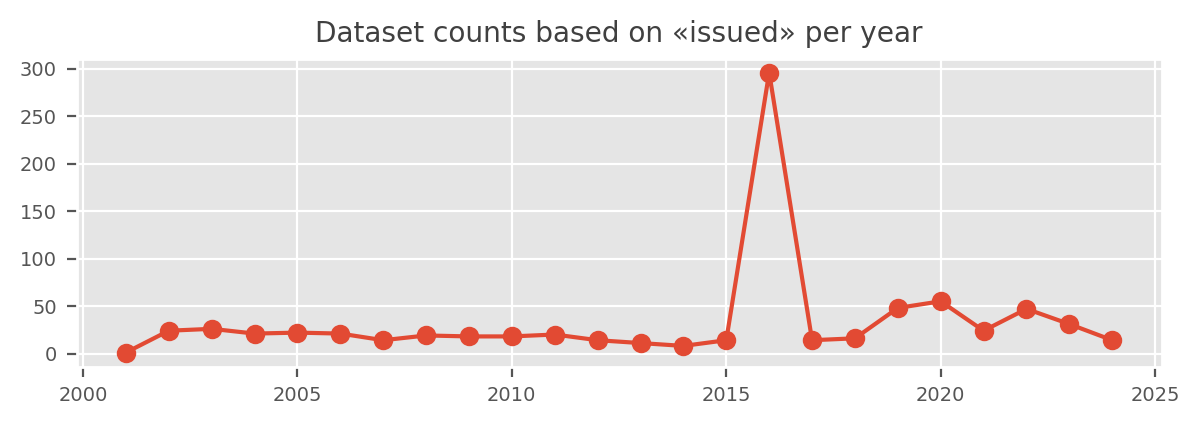

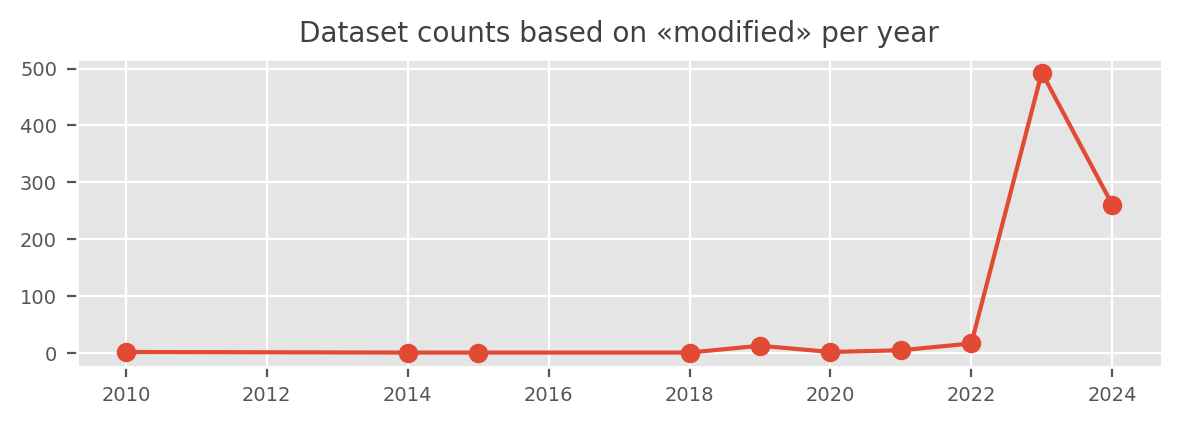

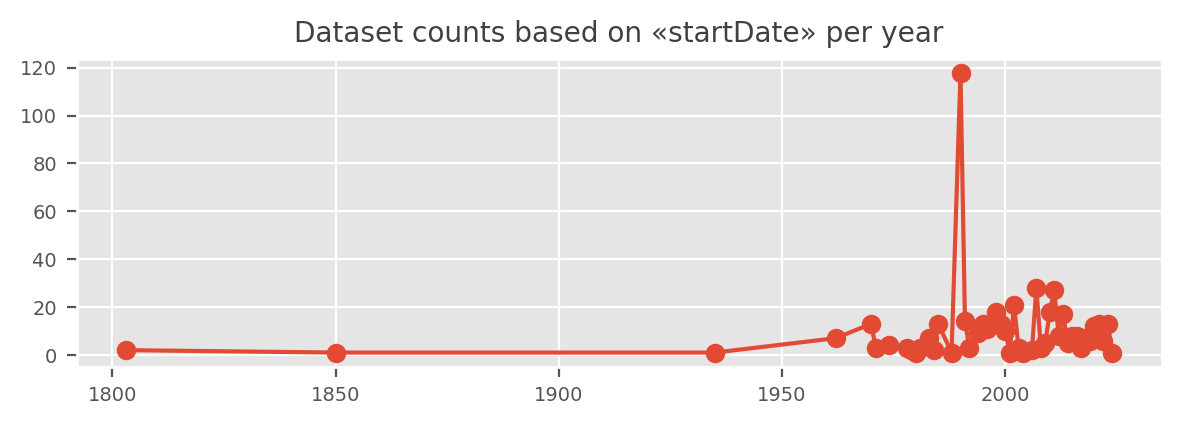

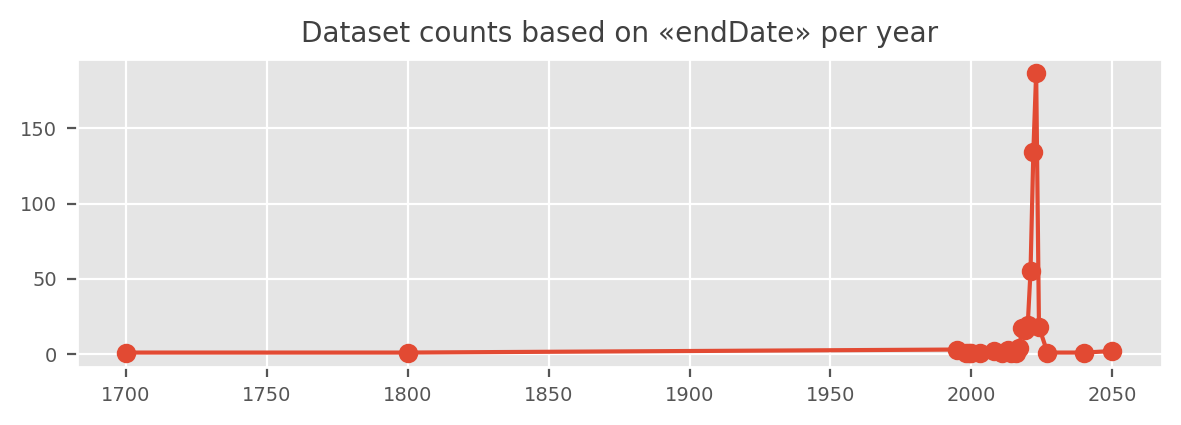

In [32]:
# Plot date features.

df.issued = pd.to_datetime(df.issued, format="%Y-%m-%dT%H:%M:%S")
df.modified = pd.to_datetime(df.modified, format="%Y-%m-%dT%H:%M:%S")
df.endDate = pd.to_datetime(df.endDate, format="%Y-%m-%d")

for date_feature in ["issued", "modified", "startDate", "endDate"]:
    fig, ax = plt.subplots(figsize=(7, 2))
    if date_feature == "startDate":
        to_drop = df.startDate.sort_values().head(2).index
        tmp = df.drop(to_drop)
        tmp = tmp.dropna(subset=["startDate"])
        tmp.startDate = pd.to_datetime(tmp.startDate, format="%Y-%m-%d")
        tmp.groupby(tmp[date_feature].dt.year)[date_feature].count().plot(
            kind="line", marker="o", ax=ax
        )
    else:
        df.groupby(df[date_feature].dt.year)[date_feature].count().plot(
            kind="line", marker="o", ax=ax
        )
    ax.set_xlabel("")
    ax.set_title(f"Dataset counts based on «{date_feature}» per year")
    plt.show(fig)

# Examine properties

## Mandatory: `identifier`
According to DCAT the property `identifier` may be used as part of the URI of the Dataset.

In [33]:
df.identifier.apply(lambda x: x.split("@")[-1]).value_counts().sort_index()

identifier
afm-kanton-zuerich                         1
aln-kanton-zuerich                         1
are-kanton-zuerich                         3
awel-kanton-zuerich                       11
awi-kanton-zuerich                         1
bildungsstatistik-kanton-zuerich           8
ekz                                        1
fachstelle-ogd-kanton-zuerich             15
finanzverwaltung-kanton-zuerich            1
gemeindeamt-kanton-zuerich                 1
gesundheitsdirektion-kanton-zuerich        9
handelsregisteramt-kanton-zuerich          1
ima-kanton-zuerich                         1
kantonspolizei-kanton-zuerich              3
oberjugendanwaltschaft-kanton-zuerich      1
personalamt-kanton-zuerich                 1
staatsarchiv-kanton-zuerich                7
staatskanzlei-kanton-zuerich               1
stadt-uster                                4
stadt-winterthur                          14
statistisches-amt-kanton-zuerich         709
tiefbauamt-kanton-zuerich                  1

## Mandatory: `contactPoint`
- `contactPoint` must contain an email address that is continuously monitored.

In [34]:
assert df.contactPoint.isna().sum() == 0
email = list(set(df.contactPoint.apply(lambda x: x[0]["email"]).values))
email = [x.lower() for x in email]
email = [x for x in email if "@" in x]
print(f"{len(email)} unique email addresses found in contactPoint.")
sorted(email)

53 unique email addresses found in contactPoint.


['andrea.schnell@statistik.ji.zh.ch',
 'basil.schlaepfer@statistik.ji.zh.ch',
 'bista@bi.zh.ch',
 'daniel.cahn@statistik.ji.zh.ch',
 'datashop@statistik.zh.ch',
 'datenlogistik@bd.zh.ch',
 'davi@kl.zh.ch',
 'dm@statistik.ji.zh.ch',
 'fachstellekultur@ji.zh.ch',
 'finanzhaushalt@fdfv.zh.ch',
 'fm-steuerung@bd.zh.ch',
 'gdstab@gd.zh.ch',
 'gian-marco.alt@bd.zh.ch',
 'hr-controlling@pa.zh.ch',
 'info.aw@bd.zh.ch',
 'info@kl.zh.ch',
 'info@open.zh.ch',
 'info@vsa.zh.ch',
 'irene.boeckmann@statistik.ji.zh.ch',
 'iris.wurmitzer@statistik.ji.zh.ch',
 'joerg.sintermann@bd.zh.ch',
 'kanzlei.hra@ji.zh.ch',
 'katharina.kaelin@statistik.ji.zh.ch',
 'kdm-kla@kapo.zh.ch',
 'kindheit@uster.ch',
 'kontakt.gaz@ji.zh.ch',
 'kultursekretariat@uster.ch',
 'luft@bd.zh.ch',
 'michael.schiess@statistik.ji.zh.ch',
 'mirjam.baumann@bd.zh.ch',
 'naturschutz@bd.zh.ch',
 'netzwirtschaft@ekz.ch',
 'nora.wight@statistik.ji.zh.ch',
 'peter.moser@statistik.ji.zh.ch',
 'quartier@uster.ch',
 'raumbeobachtung@bd.zh.ch',

In [35]:
for col in ("email", "org", "orgUnit"):
    tmp = df.contactPoint.apply(lambda x: True if x[0][col] is None else False)
    if tmp.sum() > 0:
        print(f"We have {tmp.sum()} empty {col} fields in contactPoint.\n")

    # Add issues to the list.
    issues.extend(
        [
            (x, f"Empty values in property contactPoint {col}", "Missing values")
            for x in df.loc[tmp].identifier
        ]
    )

We have 34 empty orgUnit fields in contactPoint.



## Mandatory: `publisher`

In [36]:
df.publisher.value_counts()

publisher
[Statistisches Amt des Kantons Zürich]                           709
[Fachstelle Open Government Data des Kantons Zürich]              15
[Stadt Winterthur]                                                14
[Amt für Abfall, Wasser, Energie und Luft des Kantons Zürich]     11
[Gesundheitsdirektion des Kantons Zürich]                          9
[Bildungsstatistik des Kantons Zürich]                             8
[Staatsarchiv des Kantons Zürich]                                  7
[Stadt Uster]                                                      4
[Kantonspolizei des Kantons Zürich]                                3
[Amt für Raumentwicklung des Kantons Zürich]                       3
[Personalamt des Kantons Zürich]                                   1
[Amt für Mobilität des Kantons Zürich]                             1
[Amt für Landschaft und Natur]                                     1
[Immobilienamt des Kantons Zürich]                                 1
[Elektrizitätswerke des 

## Recommended: `theme`
A Dataset may be associated with multiple themes. 

In [37]:
themes = [y for x in df.theme.values.tolist() for y in x if y is not None]
themes_categories = list(set(themes))
print(f"We have {len(themes_categories):,.0f} unique themes in the dataset.")
display(sorted(list(themes_categories)))

We have 10 unique themes in the dataset.


['http://publications.europa.eu/resource/authority/data-theme/AGRI',
 'http://publications.europa.eu/resource/authority/data-theme/ECON',
 'http://publications.europa.eu/resource/authority/data-theme/EDUC',
 'http://publications.europa.eu/resource/authority/data-theme/ENER',
 'http://publications.europa.eu/resource/authority/data-theme/ENVI',
 'http://publications.europa.eu/resource/authority/data-theme/GOVE',
 'http://publications.europa.eu/resource/authority/data-theme/HEAL',
 'http://publications.europa.eu/resource/authority/data-theme/JUST',
 'http://publications.europa.eu/resource/authority/data-theme/SOCI',
 'http://publications.europa.eu/resource/authority/data-theme/TRAN']

In [38]:
out_of_vocab = [x for x in themes_categories if x not in VOCAB_EU_THEME]
if len(out_of_vocab) > 0:
    print(f"{len(out_of_vocab)} themes are not in the EU theme vocabulary.")

In [39]:
empties = df.theme.apply(lambda x: len([y for y in x if y is None]))
if empties.sum() > 0:
    print(f"{len(empties.sum())} datasets have empty themes.")

In [40]:
duplicates = df.theme.apply(lambda x: len(x) != len(set(x)))
if duplicates.sum() > 0:
    print(f"{duplicates.sum()} datasets have duplicate themes.")

In [41]:
df["theme_count"] = df.theme.apply(lambda x: len(x))
print(
    f"Datasets have between {df.theme_count.min()} and {df.theme_count.max()} themes:"
)
display(df.theme_count.value_counts().sort_index())

Datasets have between 1 and 10 themes:


theme_count
1     547
2     222
3      18
4       4
7       1
8       2
9       1
10      1
Name: count, dtype: int64

In [42]:
print("Dataset with most themes:")
print(df[df.theme_count == df.theme_count.max()][["title"]].values[0][0])
df[df.theme_count == df.theme_count.max()].theme.values[0]

Dataset with most themes:
Statistisches Jahrbuch des Kantons Zürich


array(['http://publications.europa.eu/resource/authority/data-theme/SOCI',
       'http://publications.europa.eu/resource/authority/data-theme/EDUC',
       'http://publications.europa.eu/resource/authority/data-theme/ENER',
       'http://publications.europa.eu/resource/authority/data-theme/HEAL',
       'http://publications.europa.eu/resource/authority/data-theme/JUST',
       'http://publications.europa.eu/resource/authority/data-theme/AGRI',
       'http://publications.europa.eu/resource/authority/data-theme/GOVE',
       'http://publications.europa.eu/resource/authority/data-theme/ENVI',
       'http://publications.europa.eu/resource/authority/data-theme/TRAN',
       'http://publications.europa.eu/resource/authority/data-theme/ECON'],
      dtype=object)

In [43]:
# Print distribution of themes.
print("Distribution of themes ")
cnt = Counter(themes)
print(
    tabulate(
        pd.DataFrame(cnt.most_common(20)), showindex=False, headers=["theme", "count"]
    )
)

Distribution of themes 
theme                                                               count
----------------------------------------------------------------  -------
http://publications.europa.eu/resource/authority/data-theme/SOCI      304
http://publications.europa.eu/resource/authority/data-theme/ECON      257
http://publications.europa.eu/resource/authority/data-theme/GOVE      248
http://publications.europa.eu/resource/authority/data-theme/ENVI       99
http://publications.europa.eu/resource/authority/data-theme/TRAN       72
http://publications.europa.eu/resource/authority/data-theme/EDUC       49
http://publications.europa.eu/resource/authority/data-theme/HEAL       35
http://publications.europa.eu/resource/authority/data-theme/AGRI       19
http://publications.europa.eu/resource/authority/data-theme/ENER       11
http://publications.europa.eu/resource/authority/data-theme/JUST        9


## Recommended: `keyword`
- If a suitable keyword is available in [TERMDAT](https://www.bk.admin.ch/bk/en/home/dokumentation/languages/termdat.html) then this SHOULD be used.
- Good practice: Mark the language of the keywords with the [ISO 639-1](https://www.iso.org/obp/ui/en/#iso:std:iso:639:ed-2:v1:en) language code such as `geodata@en`.

In [44]:
if len(df[df.keyword.isna()]) > 0:
    print(f"{len(df[df.keyword.isna()])} datasets have no keywords.")
    display(df[df.keyword.isna()][["title", "keyword"]])

    # Add issues to the list.
    issues.extend(
        [
            (x, f"Empty values in property keyword", "Missing values")
            for x in df[df.keyword.isna()].identifier
        ]
    )

20 datasets have no keywords.


,title,keyword
179,Gesamtbericht Zufriedenheitsbefragung der betr...,None
180,Individualbericht Betreutenbefragung inkl. Vor...,None
181,Benchmarkingbericht Angehörige und externe Ste...,None
182,Befragung in Institutionen für Menschen mit Be...,None
183,Benchmarkingbericht der Kundenbefragung im Ber...,None
184,Vom Stolperstein zum Baustein: ein Baukasten z...,None
185,Poster zu potentiellen Stolpersteinen bei Befr...,None
186,Resultate der direkt durchgeführten Online-Bef...,None
205,Über die Grenze,None
206,Verdichtung,None


In [45]:
top_n = 50
keywords = [y for x in df.keyword.dropna().values.tolist() for y in x]
keyword_categories = list(set(keywords))
if len(keyword_categories) > 0:
    print(f"We have {len(keyword_categories):,.0f} unique keywords in the dataset.\n")
    print(f"Here are the first {top_n} keywords:")
    print(sorted(list(keyword_categories))[:top_n])

We have 455 unique keywords in the dataset.

Here are the first 50 keywords:
['abfall', 'abfallanlagen', 'abfallgebuehren', 'abgase', 'abstimmungen', 'abstimmungsergebnisse', 'abwasser', 'administrative_grenzen', 'aerzteschaft', 'ahv', 'alleinerziehende', 'alter', 'altersgruppen', 'altersheime', 'altersklassen', 'altersstruktur', 'ammoniak', 'amtliches_geschlecht', 'angestellte', 'apotheken', 'arbeitskraefte', 'arbeitslose', 'arbeitslosigkeit', 'arbeitsmarkt', 'arbeitsstaetten', 'arbeitszeitmodelle', 'armut', 'aufenthalt', 'ausbildung', 'ausbildungsniveau', 'aushub', 'auslaender*innen', 'auto', 'bahn', 'bahntransport', 'bauland', 'bautaetigkeit', 'bauvorhaben', 'bauzonen', 'beratungsangebote', 'berufsbildung', 'berufslehre', 'berufsmaturitaetsschule', 'berufsschule', 'beschaeftigte', 'beschaeftigungsgrad', 'betreuungsbeitraege', 'betriebe', 'bevoelkerung', 'bevoelkerungsbestand']


In [46]:
df["keyword_count"] = df.keyword.dropna().apply(lambda x: len(x))
print(
    f"Datasets have between {df.keyword_count.min():.0f} and {df.keyword_count.max():.0f} keywords."
)
display(df.keyword_count.value_counts().sort_index())
print("Dataset with the most keywords:")
df[df.keyword_count == df.keyword_count.max()][["title", "keyword"]].values

Datasets have between 1 and 45 keywords.


keyword_count
1.0      33
2.0      79
3.0     110
4.0      79
5.0      61
6.0     113
7.0     142
8.0      89
9.0      28
10.0     11
11.0     10
12.0      9
13.0      5
14.0      4
16.0      1
28.0      1
45.0      1
Name: count, dtype: int64

Dataset with the most keywords:


array([['COVID_19 Gesellschaftsmonitoring des Kantons Zürich',
        array(['arbeitslose', 'ausbildung', 'bahn', 'berufslehre', 'bildung',
               'energie', 'familien', 'flugbewegungen', 'flughafen',
               'flugverkehr', 'gesundheit', 'gesundheitszustand',
               'handelsregister', 'internetnutzung', 'beratungsangebote',
               'kinder', 'kinderbetreuung', 'kindergarten', 'konkurse', 'konsum',
               'langsamverkehr', 'lernende', 'luftverkehr', 'medien',
               'oeffentlicher_verkehr', 'oeffentliche_schulen', 'primarschule',
               's-bahn', 'stellensuchende', 'strassenverkehr',
               'strassenverkehrszaehlung', 'suchtkrankheiten', 'todesfaelle',
               'verkehr', 'verkehrsfrequenz', 'verkehrsmittelwahl',
               'volkswirtschaft', 'vorschulstufe', 'wirtschaft', 'corona',
               'covid-19', 'mobilitaet', 'epidemien', 'covid19', 'ogd'],
              dtype=object)                                  

In [47]:
top_n = 10
cnt = Counter(keywords)
print("Most frequent keywords")
print(
    tabulate(
        pd.DataFrame(cnt.most_common(top_n)),
        showindex=False,
        headers=["keyword", "count"],
    )
)
print()
print("Least frequent keywords")
print(
    tabulate(
        pd.DataFrame(cnt.most_common()[-top_n:]),
        showindex=False,
        headers=["keyword", "count"],
    )
)

Most frequent keywords
keyword             count
----------------  -------
ogd                   445
kanton_zuerich        364
gemeinden             361
bezirke               327
statistik.info        290
bevoelkerung          141
politik                90
demokratie             78
einwohner              73
gemeindefinanzen       54

Least frequent keywords
keyword               count
------------------  -------
gebaeudeareal             1
unbebautes_land           1
wohngebaeude              1
stickoxide                1
abgase                    1
naturschutzgebiete        1
messung                   1
jugend_und_sport          1
geschossflaeche           1
freizeitverkehr           1


## Recommended: `landingPage`

In [48]:
top_n = 10
no_landing = df[df.landingPage.isna()]
if len(no_landing) > 0:
    print(f"{len(no_landing)} datasets have no landing page.")
    print()
    print(no_landing.publisher.value_counts())
    print(f"Here are the first {top_n}:")
    display(no_landing[["title", "publisher", "landingPage"]].head(top_n))

    # Add issues to the list.
    issues.extend(
        [
            (x, f"Empty values in property landingPage", "Missing values")
            for x in df[df.landingPage.isna()].identifier
        ]
    )

400 datasets have no landing page.

publisher
[Statistisches Amt des Kantons Zürich]                           362
[Amt für Abfall, Wasser, Energie und Luft des Kantons Zürich]      9
[Bildungsstatistik des Kantons Zürich]                             8
[Fachstelle Open Government Data des Kantons Zürich]               5
[Amt für Raumentwicklung des Kantons Zürich]                       3
[Kantonspolizei des Kantons Zürich]                                2
[Gesundheitsdirektion des Kantons Zürich]                          2
[Stadt Winterthur]                                                 2
[Oberjugendanwaltschaft des Kantons Zürich]                        1
[Staatsarchiv des Kantons Zürich]                                  1
[Amt für Wirtschaft des Kantons Zürich]                            1
[Personalamt des Kantons Zürich]                                   1
[Handelsregisteramt des Kantons Zürich]                            1
[Immobilienamt des Kantons Zürich]                       

,title,publisher,landingPage
108,Abstimmungsarchiv des Kantons Zürich ab 1831,[Statistisches Amt des Kantons Zürich],None
142,Jahresrechnungen der Körperschaften des Kanton...,[Statistisches Amt des Kantons Zürich],None
171,Abstimmungsempfehlungen von Kantonsrat und Reg...,[Statistisches Amt des Kantons Zürich],None
173,Abstimmungsparolen von kantonalzürcher und nat...,[Statistisches Amt des Kantons Zürich],None
174,Web Analytics der Open Government Data des Kan...,[Fachstelle Open Government Data des Kantons Z...,None
177,Lufttemperatur und Luftfeuchte LoRa-Sensor-Mes...,"[Amt für Abfall, Wasser, Energie und Luft des ...",None
178,Sozialbericht,[Statistisches Amt des Kantons Zürich],None
179,Gesamtbericht Zufriedenheitsbefragung der betr...,[Statistisches Amt des Kantons Zürich],None
180,Individualbericht Betreutenbefragung inkl. Vor...,[Statistisches Amt des Kantons Zürich],None
181,Benchmarkingbericht Angehörige und externe Ste...,[Statistisches Amt des Kantons Zürich],None


In [49]:
# Check if landing pages are reachable.

print("Check if landing pages are reachable.\n")
landing_pages = list(set(df.landingPage.dropna().to_list()))
errors = []
for page in landing_pages:
    res = requests.get(page)
    if res.status_code != 200:
        print(f"Status code {res.status_code} for {page}")
        errors.append((res.status_code, page))

for status_code, page in errors:
    print(status_code, page)
    display(df[df.landingPage == page][["title", "landingPage"]])

    # Add issues to the list.
    issues.extend(
        [
            (
                x,
                f"landingPage not reachable: {status_code} - {page}",
                "Landing page issue",
            )
            for x in df[df.landingPage == page].identifier
        ]
    )

Check if landing pages are reachable.

Status code 202 for https://openzh.shinyapps.io/UAstat/
202 https://openzh.shinyapps.io/UAstat/


,title,landingPage
370,Web Analytics des Webauftritts des Kantons Zür...,https://openzh.shinyapps.io/UAstat/


## Optional: `accrualPeriodicity`
Vocabulary to be used: [VOCAB-EU-FREQUENCY](https://publications.europa.eu/resource/authority/frequency).

In [50]:
not_in_vocab = [
    x for x in df.accrualPeriodicity.unique() if x not in VOCAB_EU_FREQUENCY
]
if len(not_in_vocab) > 0:
    print(f"{len(not_in_vocab)} frequencies are not in the EU frequency vocabulary.\n")
    print(not_in_vocab)

12 frequencies are not in the EU frequency vocabulary.

['http://publications.europa.eu/resource/authority/frequency/annual', 'http://publications.europa.eu/resource/authority/frequency/irreg', 'http://publications.europa.eu/resource/authority/frequency/never', 'http://publications.europa.eu/resource/authority/frequency/monthly', 'http://publications.europa.eu/resource/authority/frequency/cont', 'http://publications.europa.eu/resource/authority/frequency/annual_2', 'http://publications.europa.eu/resource/authority/frequency/quarterly', 'http://publications.europa.eu/resource/authority/frequency/biennial', 'http://publications.europa.eu/resource/authority/frequency/daily', 'http://publications.europa.eu/resource/authority/frequency/weekly', 'http://publications.europa.eu/resource/authority/frequency/weekly_2', None]


In [51]:
print("Distribution of accrualPeriodicity")
display(df.accrualPeriodicity.value_counts())

Distribution of accrualPeriodicity


accrualPeriodicity
http://publications.europa.eu/resource/authority/frequency/annual       358
http://publications.europa.eu/resource/authority/frequency/never        308
http://publications.europa.eu/resource/authority/frequency/irreg         82
http://publications.europa.eu/resource/authority/frequency/cont          16
http://publications.europa.eu/resource/authority/frequency/quarterly      8
http://publications.europa.eu/resource/authority/frequency/daily          7
http://publications.europa.eu/resource/authority/frequency/monthly        6
http://publications.europa.eu/resource/authority/frequency/weekly         5
http://publications.europa.eu/resource/authority/frequency/biennial       2
http://publications.europa.eu/resource/authority/frequency/annual_2       1
http://publications.europa.eu/resource/authority/frequency/weekly_2       1
Name: count, dtype: int64

## Optional: `relation`

In [52]:
missing = df[df.relation.isna()]
if len(missing) > 0:
    print(f"We have {len(missing)} datasets without relation.\n")
    print(df[df.relation.isna()].publisher.value_counts())
    display(df[df.relation.isna()][["title", "publisher", "relation"]].head(10))

    # Add issues to the list.
    issues.extend(
        [
            (x, f"Missing value for property relations", "Missing values")
            for x in df[df.relation.isna()].identifier
        ]
    )

We have 363 datasets without relation.

publisher
[Statistisches Amt des Kantons Zürich]                           355
[Stadt Winterthur]                                                 4
[Amt für Wirtschaft des Kantons Zürich]                            1
[Amt für Landschaft und Natur]                                     1
[Fachstelle Open Government Data des Kantons Zürich]               1
[Amt für Abfall, Wasser, Energie und Luft des Kantons Zürich]      1
Name: count, dtype: int64


,title,publisher,relation
178,Sozialbericht,[Statistisches Amt des Kantons Zürich],None
179,Gesamtbericht Zufriedenheitsbefragung der betr...,[Statistisches Amt des Kantons Zürich],None
180,Individualbericht Betreutenbefragung inkl. Vor...,[Statistisches Amt des Kantons Zürich],None
181,Benchmarkingbericht Angehörige und externe Ste...,[Statistisches Amt des Kantons Zürich],None
182,Befragung in Institutionen für Menschen mit Be...,[Statistisches Amt des Kantons Zürich],None
183,Benchmarkingbericht der Kundenbefragung im Ber...,[Statistisches Amt des Kantons Zürich],None
184,Vom Stolperstein zum Baustein: ein Baukasten z...,[Statistisches Amt des Kantons Zürich],None
185,Poster zu potentiellen Stolpersteinen bei Befr...,[Statistisches Amt des Kantons Zürich],None
186,Resultate der direkt durchgeführten Online-Bef...,[Statistisches Amt des Kantons Zürich],None
188,Bodenpreise für die Zürcher Gemeinden,[Statistisches Amt des Kantons Zürich],None


In [53]:
relations = df.relation.dropna().apply(lambda x: [y["link"] for y in x]).to_list()
relations = [y for x in relations for y in x]
relations_categories = list(set(relations))
print(f"We have {len(relations_categories):,.0f} unique relations in the dataset.")
cnt = Counter(relations)
display(cnt.most_common(10))

We have 156 unique relations in the dataset.


[('https://openzh.github.io/starter-code-openZH/', 405),
 ('https://www.zh.ch/de/politik-staat/gesetze-beschluesse/gesetzessammlung/zhlex-os/erlass-431_1-70-359.html',
  321),
 ('https://www.zh.ch/de/politik-staat/statistik-daten/datenkatalog.html#/datasets/693@statistisches-amt-kanton-zuerich/distributions/4844',
  14),
 ('https://www.zh.ch/de/politik-staat/statistik-daten/datenkatalog.html#/datasets/690@statistisches-amt-kanton-zuerich/distributions/4843',
  13),
 ('https://www.zh.ch/de/politik-staat/gesetze-beschluesse/gesetzessammlung/zhlex-os/erlass-170_6-68-452.html',
  11),
 ('https://www.zh.ch/de/bildung/bildungssystem/zahlen-fakten.html', 8),
 ('https://maps.zh.ch/system/docs/afv/KTZH_AFV_OeV_Gueteklassen_2_1_2020_08_25.pdf',
  7),
 ('https://pub.bista.zh.ch/de/aktuell/publikationen/', 7),
 ('https://www.zh.ch/de/gesundheit/coronavirus.html', 5),
 ('https://github.com/openZH/dokumentation_archiv_wahlresultate', 4)]

## Additional: `seeAlso`

In [54]:
print(f"We have {df.seeAlso.isna().sum()} datasets without seeAlso.")
display(df[df.seeAlso.isna()].publisher.value_counts())

# Add issues to the list.
issues.extend(
    [
        (x, f"Missing value for property relations", "Missing values")
        for x in df[df.seeAlso.isna()].identifier
    ]
)

We have 332 datasets without seeAlso.


publisher
[Statistisches Amt des Kantons Zürich]                           317
[Amt für Abfall, Wasser, Energie und Luft des Kantons Zürich]      5
[Fachstelle Open Government Data des Kantons Zürich]               3
[Gemeindeamt des Kantons Zürich]                                   1
[Gesundheitsdirektion des Kantons Zürich]                          1
[Amt für Wirtschaft des Kantons Zürich]                            1
[Personalamt des Kantons Zürich]                                   1
[Amt für Landschaft und Natur]                                     1
[Stadt Winterthur]                                                 1
[Finanzverwaltung des Kantons Zürich]                              1
Name: count, dtype: int64

In [55]:
see_also = [y for x in df.seeAlso.dropna() for y in x]
see_also_categories = list(set(see_also))
print(
    f"We have {len(see_also_categories):,.0f} unique seeAlso datasets in the dataset."
)
cnt = Counter(see_also)
display(cnt.most_common(10))
df[df.identifier.isin([x[0] for x in cnt.most_common(10)])][["title"]]

We have 463 unique seeAlso datasets in the dataset.


[('55@statistisches-amt-kanton-zuerich', 18),
 ('60@statistisches-amt-kanton-zuerich', 17),
 ('148@statistisches-amt-kanton-zuerich', 17),
 ('195@statistisches-amt-kanton-zuerich', 16),
 ('74@statistisches-amt-kanton-zuerich', 14),
 ('92@statistisches-amt-kanton-zuerich', 14),
 ('93@statistisches-amt-kanton-zuerich', 14),
 ('95@statistisches-amt-kanton-zuerich', 14),
 ('97@statistisches-amt-kanton-zuerich', 14),
 ('99@statistisches-amt-kanton-zuerich', 14)]

,title
15,Steuerpflichtige juristische Personen [Anz.]
377,4-Personenhaushalte [Anz.]
382,Gebäudevolumen: Zunahme [%]
384,Geb.Vol. Dienstleistungen: Anteil [%]
385,Geb.Vol. Dienstleistungen: Zunahme [%]
386,Geb.Vol. Industrie/Lager: Zunahme [%]
387,Geb.Vol. Infrastruktur: Zunahme [%]
389,Geb.Vol. Landwirtschaft: Anteil [%]
425,Personenwagen [Anz.]
477,Steuerertrag von juristischen Personen [Mio.Fr.]


# Examine distributions

## Global checks

### Structure

In [84]:
df["ressource_count"] = df.distribution.apply(len)
print(
    f"Datasets have between {df.ressource_count.min()} and {df.ressource_count.max()} ressources."
)
display(df.ressource_count.value_counts().sort_index())

Datasets have between 1 and 65 ressources.


ressource_count
1     687
2      38
3      14
4      10
5       6
6       5
7       3
8       8
9       3
10      1
11      2
12      3
13      1
14      6
16      2
18      1
20      1
22      1
26      1
31      1
37      1
65      1
Name: count, dtype: int64

In [57]:
# Create dataframe from distributions.

results = []
for idx, row in df.iterrows():
    tmp = [pd.json_normalize(x) for x in row.distribution]
    tmp = pd.concat(tmp)
    tmp["identifier"] = row.identifier
    results.append(tmp)

dist = pd.concat(results)
dist.reset_index(drop=True, inplace=True)

In [58]:
print(f"We have {len(dist):,.0f} ressources in the {len(df)} datasets.")
print()
display(dist.info())

We have 1,433 ressources in the 796 datasets.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   accessUrl    1433 non-null   object 
 1   byteSize     1349 non-null   float64
 2   description  508 non-null    object 
 3   downloadUrl  1406 non-null   object 
 4   format       1433 non-null   object 
 5   issued       1433 non-null   object 
 6   ktzhDistId   1433 non-null   int64  
 7   language     1367 non-null   object 
 8   license      1433 non-null   object 
 9   mediaType    1433 non-null   object 
 10  modified     1433 non-null   object 
 11  title        1433 non-null   object 
 12  identifier   1433 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 145.7+ KB


None

### Properties

In [59]:
# Extract the various requirements for each property.

mandatory = dcat_dist[dcat_dist.requirement == "M"].uri.tolist()
recommended = dcat_dist[dcat_dist.requirement == "R"].uri.tolist()
optional = dcat_dist[dcat_dist.requirement == "O"].uri.tolist()

print("The distributions contain the following properties:\n")

for name, cols in zip(
    ["mandatory", "recommended", "optional"],
    [mandatory, recommended, optional],
):
    present = [x for x in cols if x in dist.columns]
    missing = [x for x in cols if x not in dist.columns]
    missing_len = len(missing)
    if missing == []:
        missing = ""
        print(
            f"{len(cols) - missing_len} of {len(cols)} {name} properties.\n{present}\n{missing_len} missing."
        )
    else:
        print(
            f"{len(cols) - missing_len} of {len(cols)} {name} properties.\n{present}\n{missing_len} missing: {missing}"
        )
    print()

additional = [x for x in dist.columns if x not in dcat_dist.uri.tolist()]
print(f"{len(additional)} additional properties: {additional}")

The distributions contain the following properties:

1 of 2 mandatory properties.
['license']
1 missing: ['accessURL']

5 of 8 recommended properties.
['description', 'format', 'title', 'modified', 'issued']
3 missing: ['availability', 'rights', 'temporalResolution']

4 of 12 optional properties.
['byteSize', 'identifier', 'language', 'mediaType']
8 missing: ['accessService', 'checksum', 'coverage', 'page', 'downloadURL', 'image', 'conformsTo', 'packageFormat']

3 additional properties: ['accessUrl', 'downloadUrl', 'ktzhDistId']


In [60]:
# Fix DCAT erroneous casing of properties.
dcat_dist.replace("accessURL", "accessUrl", inplace=True)
dcat_dist.replace("downloadURL", "downloadUrl", inplace=True)

### Missing values

In [61]:
# Extract the various requirements for each property that are actually present in the dataset.
present_mandatory = [x for x in mandatory if x in dist.columns]
present_recommended = [x for x in recommended if x in dist.columns]
present_optional = [x for x in optional if x in dist.columns]

# Check for missing values in the dataset according to the requirements.
for name, cols in zip(
    ["Mandatory", "Recommended", "Optional", "Additional"],
    [present_mandatory, present_recommended, present_optional, additional],
):
    missing = [(x, dist[x].isna().sum()) for x in cols if dist[x].isna().sum() > 0]
    if missing == []:
        print(f"Missing {name} properties:\nNone")
        print()
    else:
        tmp = pd.DataFrame(missing, columns=["property", "missing_count"]).sort_values(
            "missing_count", ascending=False
        )
        print(f"Missing in {name}:")
        print(tabulate(tmp, headers="keys", showindex=False))
        print()

Missing Mandatory properties:
None

Missing in Recommended:
property       missing_count
-----------  ---------------
description              925

Missing in Optional:
property      missing_count
----------  ---------------
byteSize                 84
language                 66

Missing in Additional:
property       missing_count
-----------  ---------------
downloadUrl               27



In [62]:
for col in dist.columns:
    missing = dist[col].isna()
    if missing.sum() > 0:
        # Add issues to the list.
        issues.extend(
            [
                (
                    x,
                    f"Missing value for property distribution > {col}",
                    "Missing values",
                )
                for x in dist[dist[col].isna()].identifier
            ]
        )

### Duplicates

In [63]:
assert len(dist.drop_duplicates()) == len(dist)

### Examine properties

#### `title` and `description`

In [64]:
tmp = pd.merge(df, dist, on="identifier", how="inner")
tmp = tmp[tmp.title_x == tmp.title_y]
print(
    f"{tmp.identifier.nunique()} of {len(df)} datasets have the dataset title as the ressources title"
)

# Add issues to the list.
issues.extend(
    [
        (x, f"Dataset title is identical with ressource title", "Text issue")
        for x in tmp.identifier
    ]
)

tmp = pd.merge(df, dist, on="identifier", how="inner")
tmp = tmp[tmp.description_x == tmp.description_y]
print(
    f"{tmp.identifier.nunique()} of {len(df)} datasets have the dataset description as the ressources description."
)

# Add issues to the list.
issues.extend(
    [
        (
            x,
            f"Dataset description is identical with ressource description",
            "Text issue",
        )
        for x in tmp.identifier
    ]
)

619 of 796 datasets have the dataset title as the ressources title
13 of 796 datasets have the dataset description as the ressources description.


In [65]:
empties = dist[dist.description.isin(["NA", "keine", "null", ""])]
if len(empties) > 0:
    print(f"{len(empties)} distributions have empty descriptions.")
    display(empties[["title", "description"]])

    # Add issues to the list.
    issues.extend(
        [
            (
                x,
                f"Hidden null in distribution > description",
                "Text issue",
            )
            for x in empties.identifier
        ]
    )

In [66]:
# TODO: Check for HTML or XML tags in descriptions.
# tmp = dist.dropna(subset=["description"])
# tmp[tmp.description.str.contains("<|>")].description.values

Descriptions contain meta information about ressources rather than a description about the content itself.

In [67]:
display(
    dist[dist.description.duplicated(keep=False)].description.value_counts().head(10)
)

description
Informationen zum Datensatz siehe abgelegte Datensatzbeschreibung                                                                                                                                                      21
Um die Stabilität unserer Server nicht zu gefährden, bitten wir die Konsumenten auf eine Direktverlinkung zu verzichten und stattdessen das File in regelmässigen Abständen auf den eigenen Server herunterzuladen.    17
Anzahl erhaltener Stimmen pro Liste und Gebiet                                                                                                                                                                         10
Anzahl erhaltener Stimmen pro Partei und Gebiet. Die Zuteilung der Listen zu einer Partei erfolgt gemäss der Ressource "Zuordnungstabelle Listen – Parteien" dieses Datasets.                                          10
Ausgenommen sind die Datensätze, die von der Geoinformation des Kantons Zürich auf opendata.swiss verwaltet werden. 

#### `accessUrl` and `downloadUrl`

In [68]:
for property in ["accessUrl", "downloadUrl"]:
    missing = dist[dist[property].isna()]
    if len(missing) > 0:
        print(f"{len(missing)} distributions have no {property}.")
        display(missing[["title", property]])

27 distributions have no downloadUrl.


,title,downloadUrl
367,SRU-Schnittstelle - Archivinformationssystem d...,None
368,Suchmaske - Archivinformationssystem des Staat...,None
514,Kantonale Leerwohnungsziffer seit 1984,None
565,Echtzeit Verkehrszähldaten MIV im Kanton Zürich,None
754,Mitglieder des Kantonsrates des Kantons Zürich,None
755,Fraktionen im Gever des Kantonsrates des Kanto...,None
756,Beispielabfrage: Sitzungs- und Geschäftsdokume...,None
757,Sitzungen (Agenda) des Kantonsrates des Kanton...,None
758,Geschäfte des Kantonsrates des Kantons Zürich,None
759,Beispielabfrage: Fraktionsmitglieder des Kanto...,None


In [69]:
tmp = dist[dist.accessUrl != dist.downloadUrl][["title", "accessUrl", "downloadUrl"]]
if len(tmp) > 0:
    print(f"{len(tmp)} datasets have different access and download URLs.")
    display(tmp)

27 datasets have different access and download URLs.


,title,accessUrl,downloadUrl
367,SRU-Schnittstelle - Archivinformationssystem d...,https://suche.staatsarchiv.djiktzh.ch/SRU/?ope...,None
368,Suchmaske - Archivinformationssystem des Staat...,https://suche.staatsarchiv.djiktzh.ch,None
514,Kantonale Leerwohnungsziffer seit 1984,https://www.zh.ch/de/politik-staat/gemeinden/g...,None
565,Echtzeit Verkehrszähldaten MIV im Kanton Zürich,https://vdp.zh.ch/openapi,None
754,Mitglieder des Kantonsrates des Kantons Zürich,https://parlzhcdws.cmicloud.ch/parlzh2/cdws/In...,None
755,Fraktionen im Gever des Kantonsrates des Kanto...,https://parlzhcdws.cmicloud.ch/parlzh2/cdws/In...,None
756,Beispielabfrage: Sitzungs- und Geschäftsdokume...,https://parlzhcdws.cmicloud.ch/parlzh5/cdws/Fi...,None
757,Sitzungen (Agenda) des Kantonsrates des Kanton...,https://parlzhcdws.cmicloud.ch/parlzh3/cdws/In...,None
758,Geschäfte des Kantonsrates des Kantons Zürich,https://parlzhcdws.cmicloud.ch/parlzh5/cdws/In...,None
759,Beispielabfrage: Fraktionsmitglieder des Kanto...,https://parlzhcdws.cmicloud.ch/parlzh2/cdws/In...,None


In [70]:
display(dist.accessUrl.apply(lambda x: x.split("https://")[0]).value_counts())
display(dist.accessUrl.apply(lambda x: x.split("://")[0]).value_counts())

display(
    dist.downloadUrl.dropna().apply(lambda x: x.split("https://")[0]).value_counts()
)
display(dist.downloadUrl.dropna().apply(lambda x: x.split("://")[0]).value_counts())

accessUrl
                                                                        1431
http://www.wahlen.zh.ch/kommunal/kommunale_resultate_2021_11_28.json       1
http://www.wahlen.zh.ch/kommunal/kommunale_resultate_2022_02_13.json       1
Name: count, dtype: int64

accessUrl
https    1431
http        2
Name: count, dtype: int64

downloadUrl
                                                                        1404
http://www.wahlen.zh.ch/kommunal/kommunale_resultate_2021_11_28.json       1
http://www.wahlen.zh.ch/kommunal/kommunale_resultate_2022_02_13.json       1
Name: count, dtype: int64

downloadUrl
https    1404
http        2
Name: count, dtype: int64

#### `format`

In [71]:
print("Percentages of distribution types\n")
dist_perc = dist.format.value_counts(normalize=True) * 100
print(f"{dist_perc['CSV']:.2f}% CSV files")
print(f"{dist_perc['PDF']:.2f}% PDF files")
display(dist_perc)
print()

Percentages of distribution types

53.66% CSV files
30.08% PDF files


format
CSV       53.663643
PDF       30.076762
XLSX       8.164689
JSON       1.814375
XML        1.674808
XLS        1.605024
ZIP        1.116539
TXT        0.837404
HTML       0.767620
JSONLD     0.139567
DOCX       0.069784
JS         0.069784
Name: proportion, dtype: float64

#### `mediaType`

In [72]:
print("Distribution of media types")
display(dist.mediaType.value_counts())

Distribution of media types


mediaType
text/csv                                                                   737
application/pdf                                                            431
application/vnd.openxmlformats-officedocument.spreadsheetml.sheet          117
application/vnd.ms-excel                                                    55
application/json                                                            26
application/xml                                                             24
application/x-zip-compressed                                                16
text/plain                                                                  12
text/html                                                                   11
application/ld+json                                                          2
application/vnd.openxmlformats-officedocument.wordprocessingml.document      1
text/javascript                                                              1
Name: count, dtype: int64

In [73]:
print("mediaType of CSV ressources:")
display(dist[dist.format == "CSV"].mediaType.value_counts())

mediaType of CSV ressources:


mediaType
text/csv                    737
application/vnd.ms-excel     32
Name: count, dtype: int64

#### `byteSize`

In [74]:
no_bytesize = dist.byteSize.isna()
print(f"{no_bytesize.sum()} ressources have no byteSize.")
display(dist[dist.byteSize.isna()][["description", "mediaType", "byteSize"]].head(10))

print(f"{sum(dist.byteSize == 0)} ressources have a byteSize of 0.")
display(dist[dist.byteSize == 0][["description", "mediaType", "byteSize"]].head(10))

84 ressources have no byteSize.


,description,mediaType,byteSize
110,Eidgenössische Vorlagen: 1. Volksinitiative «J...,application/json,NaN
111,Eidgenössische Vorlagen: 1. Volksinitiative fü...,application/json,NaN
178,Die Daten werden in Form von Linked Open Data ...,application/ld+json,NaN
188,"Ausgenommen sind die Datensätze, die von der G...",text/csv,NaN
216,"Ausgenommen sind die Datensätze, die von der G...",text/csv,NaN
217,"Ausgenommen sind die Datensätze, die von der G...",text/csv,NaN
218,"Ausgenommen sind die Datensätze, die von der G...",text/csv,NaN
367,Spezifikation der XML-Schnittstelle: http://ww...,application/xml,NaN
368,None,text/html,NaN
565,Der Datensatz umfasst Einzelfahrzeugdaten in E...,application/json,NaN


2 ressources have a byteSize of 0.


,description,mediaType,byteSize
1343,None,text/csv,0.0
1364,None,text/csv,0.0


In [75]:
size_total = dist.byteSize.dropna().sum() / 1024 / 1024 / 1024
print(f"{size_total:.2f} GB total size of all ressources according to byteSize.")
dist.byteSize.dropna().astype(float).describe().apply(lambda x: f"{x:,.0f}")

5.69 GB total size of all ressources according to byteSize.


count          1,349
mean       4,530,665
std       19,623,925
min                0
25%           90,781
50%          303,979
75%          969,342
max      279,127,397
Name: byteSize, dtype: object

In [76]:
display(dist.byteSize.value_counts().sort_index())
dist[dist.byteSize == 0][["accessUrl", "title"]].values

# Add issues to the list.
issues.extend(
    [
        (
            x,
            f"Value of 0 in distribution > byteSize",
            "Likely erroneous value",
        )
        for x in dist[dist.byteSize == 0].identifier
    ]
)

byteSize
0.0            2
1.0            1
5.0            1
179.0          1
198.0          1
              ..
194592131.0    1
202424352.0    1
244841173.0    1
277922114.0    1
279127397.0    1
Name: count, Length: 1338, dtype: int64

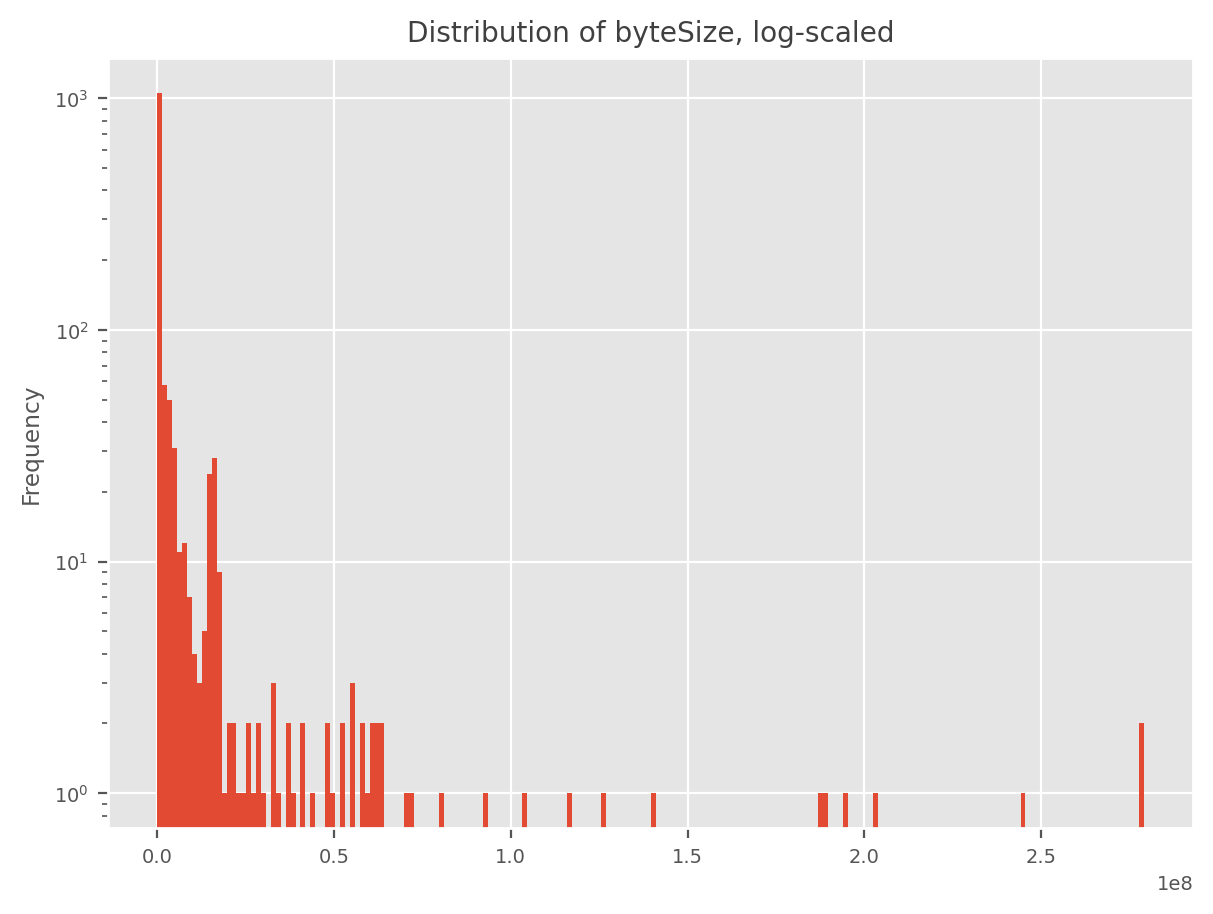

In [77]:
fig, ax = plt.subplots(figsize=FIGSIZE)
dist.byteSize.dropna().plot(
    kind="hist", bins=200, title="Distribution of byteSize, log-scaled", ax=ax
)
ax.set_yscale("log")
plt.show()

In [78]:
dist[(dist.byteSize > 0) & (dist.byteSize < 10)][["title", "accessUrl"]].values

array([['Kantonale Leerwohnungsziffer seit 1984',
        'https://www.zh.ch/de/politik-staat/gemeinden/gemeindeportraet.html?tab=indikatoren&jahr=0&indikatoren=381,373&gebietstyp=8&gebiet=195'],
       ['COVID_19 PCR-Tests und besorgniserregende Virusmutationen im Kanton Zürich',
        'https://raw.githubusercontent.com/openZH/covid_19/master/fallzahlen_kanton_zh/COVID19_VOC_Kanton_ZH.csv']],
      dtype=object)

#### `language`

- The property MUST be set if the distribution is language-dependent, or if it is given in some of the languages German, French, Italian and English but not in all four languages.
- CV to be used: [VOCAB-EU-LANGUAGE](https://publications.europa.eu/resource/authority/language)

In [79]:
missing = dist.language.isna()
print(f"{missing.sum()} ressources have no value for language.")
display(dist[missing][["title", "language"]].sample(20))

66 ressources have no value for language.


,title,language
601,Kandidierende 1. Wahlgang Ersatzwahl Regierung...,None
773,Steuererträge nach Vermögensklassen,None
289,LoRa-Sensor-Messwerte 2022/06,None
292,LoRa-Sensor-Messwerte 2022/09,None
604,Resultate 1. Wahlgang Gesamterneuerungswahl Re...,None
672,Benchmarking Praktika 2022 Gesamtbericht,None
1233,Questionaire_Benchmark_Persuisse_francais,None
602,Resultate 1. Wahlgang Gesamterneuerungswahl Re...,None
291,LoRa-Sensor-Messwerte 2022/08,None
96,Bezügerquote der bedarfsabh. Sozialleistungen [%],None


In [80]:
dist.language.value_counts()

language
de    1367
Name: count, dtype: int64

# Create dataframe of issues and export as an Excel file

In [87]:
df_issues = pd.DataFrame(issues, columns=["identifier", "issue", "category"])

print(f"{len(df_issues)} issues found in {df_issues.identifier.nunique()} datasets.")
display(df_issues.category.value_counts())

df_issues["link"] = df_issues.identifier.apply(
    lambda x: f"{BASELINK_DATASHOP}{x}"
)
timestamp = datetime.now().strftime("%Y%m%d")

df_issues["publisher"] = df_issues.identifier.str.split("@").str[1]
cols = ["identifier", "publisher", "issue", "category", "link"]
df_issues = df_issues[cols]

df_issues.to_excel(f"_results/metadata_issues_{timestamp}.xlsx", index=False)

4946 issues found in 785 datasets.


category
Missing values            3995
Text issue                 741
Duplicate                  148
Hidden nulls                57
Date issue                   2
Likely erroneous value       2
Landing page issue           1
Name: count, dtype: int64

::: {.content-hidden}
# Check if all ressources are downloadable
:::


In [82]:
# errors = []

# for name, data in tqdm(dist.iterrows()):
#     try:
#         res = requests.get(data.accessUrl)
#         if res.status_code != 200:
#             print(f"Status code {res.status_code} for {data.accessUrl}")
#         else:
#             filename = data.accessUrl.split("/")[-1]
#             # Set an appropriate path to store the files.
#             with open(f"_downloads/{name}_{filename}", "wb") as f:
#                 f.write(res.content)
#     except Exception as e:
#         print(f"Error for {data.accessUrl}: {e}")
#         errors.append(data.accessUrl)